# Model Training and Testing for the "Complete" Dataset

## Loading the dataset

In [ ]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import tensorflow
import keras
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, cross_validate, RandomizedSearchCV
import logging
import warnings
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import seaborn as sns
from sklearn.inspection import permutation_importance
import joblib

2024-12-02 10:01:45.583631: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Load in the training and test datasets
X_trainval = pd.read_csv('Data/X_trainval.csv')
y_trainval = pd.read_csv('Data/y_trainval.csv').values.ravel() # ravel to convert to 1D array
X_test = pd.read_csv('Data/X_test.csv')
y_test = pd.read_csv('Data/y_test.csv').values.ravel() # ravel to convert to 1D array

In [7]:
pd.set_option('display.max_columns', None)
X_trainval.head()

,PedPed,Barrier,NumberOfCharacters,DiffNumberOFCharacters,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Finance_access,ICT,Industry_activity,Overall_index,Research_and_development,Skills,Total,Males,Females,Passengers,Pedestrians,AttributeLevel_Female,AttributeLevel_Fit,AttributeLevel_High,AttributeLevel_Hoomans,AttributeLevel_Less,AttributeLevel_Low,AttributeLevel_Male,AttributeLevel_More,AttributeLevel_Old,AttributeLevel_Pets,AttributeLevel_Rand,AttributeLevel_Young,ScenarioTypeStrict_Fitness,ScenarioTypeStrict_Gender,ScenarioTypeStrict_Random,ScenarioTypeStrict_Social Status,ScenarioTypeStrict_Species,ScenarioTypeStrict_Utilitarian,CrossingSignal_1,CrossingSignal_2,Clusters_1,Clusters_2
0,0,0,-1.276396,-0.464869,-0.530204,-0.530815,-0.230192,-0.220212,-0.346497,-0.346527,-0.337149,-0.337838,-0.302409,-0.338291,-0.337241,-0.220455,-0.307995,-0.308182,1.648151,-0.345566,-0.282318,-0.282461,-0.289281,-0.289012,0.807851,-0.198822,0.060511,0.993754,1.233110,0.190914,0.683655,0.516913,1.140910,0.445196,0.293055,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
1,1,0,-1.276396,-0.464869,-0.530204,-0.530815,-0.230192,-0.220212,-0.346497,-0.346527,-0.337149,-0.337838,-0.302409,-0.338291,-0.337241,-0.220455,-0.307995,-0.308182,-0.346215,-0.345566,2.810220,-0.282461,-0.289281,-0.289012,0.807851,-0.198822,0.060511,0.993754,1.233110,0.190914,0.683655,0.516913,1.140910,0.445196,0.293055,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,1,0,-1.276396,-0.464869,-0.530204,-0.530815,-0.230192,-0.220212,-0.346497,-0.346527,-0.337149,-0.337838,-0.302409,-0.338291,-0.337241,-0.220455,-0.307995,-0.308182,-0.346215,-0.345566,-0.282318,-0.282461,-0.289281,1.558407,0.807851,0.994122,0.060511,0.267560,-0.169395,0.190914,-0.631484,-0.674421,-0.458640,0.299741,-0.700813,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,1,0,-1.276396,-0.464869,-0.530204,-0.530815,-0.230192,-0.220212,-0.346497,-0.346527,-0.337149,-0.337838,2.004965,-0.338291,-0.337241,-0.220455,-0.307995,-0.308182,-0.346215,-0.345566,-0.282318,-0.282461,-0.289281,-0.289012,0.807851,0.596474,-1.120430,-0.095537,-1.104397,0.995401,-1.249796,-1.171833,-1.405742,-0.949122,-1.210715,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
4,0,1,0.733421,-0.464869,-0.530204,-0.530815,-0.230192,-0.220212,-0.346497,-0.346527,-0.337149,-0.337838,-0.302409,-0.338291,-0.337241,-0.220455,-0.307995,-0.308182,-0.346215,-0.345566,-0.282318,-0.282461,-0.289281,7.100665,-2.586011,0.994122,-0.529959,-1.547926,-1.104397,-1.820303,0.222375,0.240572,0.193808,1.687760,1.983842,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [9]:
# Size of the training and test datasets
print(len(X_trainval), len(X_test))

1124187 281047


## Model Training, Evaluation and Comparisson

### Dummy Classifier

In [ ]:
model_dc = DummyClassifier(strategy='uniform', random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores = cross_validate(model_dc, X_trainval, y_trainval, cv=kf, scoring=scoring)

results_dc = pd.DataFrame(scores)
results_dc.to_csv('Output/results_dc.csv')

print(f"Mean validation accuracy: {scores['test_accuracy'].mean()}")
print(f"Mean validation precision: {scores['test_precision'].mean()}")
print(f"Mean validation recall: {scores['test_recall'].mean()}")
print(f"Mean validation F1: {scores['test_f1'].mean()}")
print(f"Mean validation AUC: {scores['test_roc_auc'].mean()}")

Mean validation accuracy: 0.4997344747804413
Mean validation precision: 0.4997352946401606
Mean validation recall: 0.5004425422866902
Mean validation F1: 0.5000885254067599
Mean validation AUC: 0.5


### Binary Logistic Regression

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END .max_iter=500, penalty=None, solver=saga, tol=0.001; total time= 5.2min
[CV] END C=10, max_iter=200, penalty=l1, solver=liblinear, tol=0.0001; total time= 7.1min
[CV] END .max_iter=500, penalty=None, solver=saga, tol=0.001; total time= 2.5min
[CV] END C=0.1, max_iter=200, penalty=l2, solver=saga, tol=0.01; total time=  43.2s
[CV] END C=0.1, max_iter=200, penalty=l2, solver=saga, tol=0.01; total time=  44.7s
[CV] END C=10, max_iter=200, penalty=l1, solver=liblinear, tol=0.0001; total time=10.0min
[CV] END C=0.1, max_iter=200, penalty=l2, solver=saga, tol=0.01; total time=  43.2s
[CV] END C=0.01, l1_ratio=0.9, max_iter=100, penalty=elasticnet, solver=saga, tol=0.01; total time=  40.4s
[CV] END C=0.01, l1_ratio=0.9, max_iter=100, penalty=elasticnet, solver=saga, tol=0.01; total time=  34.7s
[CV] END C=0.01, l1_ratio=0.9, max_iter=100, penalty=elasticnet, solver=saga, tol=0.01; total time=  42.0s
[CV] END .max_iter=500, 

/Users/timoklein/Library/CloudStorage/OneDrive-Personal/Universiteit/Studie/M_Data_Science_and_Society/year_2/Thesis/Code/timoklein/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, l1_ratio=0.1, max_iter=100, penalty=elasticnet, solver=saga, tol=0.0001; total time= 7.0min
[CV] END C=0.001, l1_ratio=0.7, max_iter=200, penalty=elasticnet, solver=saga, tol=0.0001; total time= 1.6min


/Users/timoklein/Library/CloudStorage/OneDrive-Personal/Universiteit/Studie/M_Data_Science_and_Society/year_2/Thesis/Code/timoklein/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, l1_ratio=0.1, max_iter=100, penalty=elasticnet, solver=saga, tol=0.0001; total time= 6.9min
[CV] END C=0.001, l1_ratio=0.7, max_iter=200, penalty=elasticnet, solver=saga, tol=0.0001; total time= 1.6min
[CV] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001; total time=  29.1s
[CV] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001; total time=  27.5s
[CV] END C=0.001, l1_ratio=0.7, max_iter=200, penalty=elasticnet, solver=saga, tol=0.0001; total time= 1.6min
[CV] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs, tol=0.0001; total time=  36.2s


/Users/timoklein/Library/CloudStorage/OneDrive-Personal/Universiteit/Studie/M_Data_Science_and_Society/year_2/Thesis/Code/timoklein/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, l1_ratio=0.1, max_iter=100, penalty=elasticnet, solver=saga, tol=0.0001; total time= 8.6min
[CV] END C=100, l1_ratio=0.5, max_iter=100, penalty=elasticnet, solver=saga, tol=0.001; total time= 2.9min
[CV] END C=100, l1_ratio=0.1, max_iter=100, penalty=elasticnet, solver=saga, tol=0.01; total time=  46.8s
[CV] END C=100, l1_ratio=0.1, max_iter=100, penalty=elasticnet, solver=saga, tol=0.01; total time=  48.0s
[CV] END C=100, l1_ratio=0.5, max_iter=100, penalty=elasticnet, solver=saga, tol=0.001; total time= 4.5min
[CV] END C=100, l1_ratio=0.1, max_iter=100, penalty=elasticnet, solver=saga, tol=0.01; total time= 1.1min
[CV] END C=10, l1_ratio=0.7, max_iter=200, penalty=elasticnet, solver=saga, tol=0.01; total time= 1.0min
[CV] END C=10, l1_ratio=0.7, max_iter=200, penalty=elasticnet, solver=saga, tol=0.01; total time= 1.2min
[CV] END C=10, max_iter=100, penalty=l2, solver=liblinear, tol=0.01; total time=  56.8s
[CV] END C=10, max_iter=100, penalty=l2, solver=liblinear, tol

/Users/timoklein/Library/CloudStorage/OneDrive-Personal/Universiteit/Studie/M_Data_Science_and_Society/year_2/Thesis/Code/timoklein/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, max_iter=100, penalty=l2, solver=saga, tol=0.0001; total time= 4.7min
[CV] END C=10, max_iter=100, penalty=l1, solver=liblinear, tol=0.001; total time= 1.1min


/Users/timoklein/Library/CloudStorage/OneDrive-Personal/Universiteit/Studie/M_Data_Science_and_Society/year_2/Thesis/Code/timoklein/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/timoklein/Library/CloudStorage/OneDrive-Personal/Universiteit/Studie/M_Data_Science_and_Society/year_2/Thesis/Code/timoklein/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=100, max_iter=100, penalty=l2, solver=saga, tol=0.0001; total time= 6.0min
[CV] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=elasticnet, solver=saga, tol=0.0001; total time= 2.5min
[CV] END C=100, max_iter=100, penalty=l2, solver=saga, tol=0.0001; total time= 6.5min
[CV] END C=10, max_iter=100, penalty=l1, solver=liblinear, tol=0.001; total time= 4.3min
[CV] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=elasticnet, solver=saga, tol=0.0001; total time= 1.7min
[CV] END C=0.001, l1_ratio=0.9, max_iter=200, penalty=elasticnet, solver=saga, tol=0.0001; total time= 1.6min
[CV] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs, tol=0.01; total time=  27.7s
[CV] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs, tol=0.01; total time=  28.5s
[CV] END C=10, max_iter=100, penalty=l2, solver=liblinear, tol=0.0001; total time= 3.3min
[CV] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs, tol=0.01; total time=  21.5s
[CV] END C=10, max_iter=100, penalty=l2, solver=liblinear, to

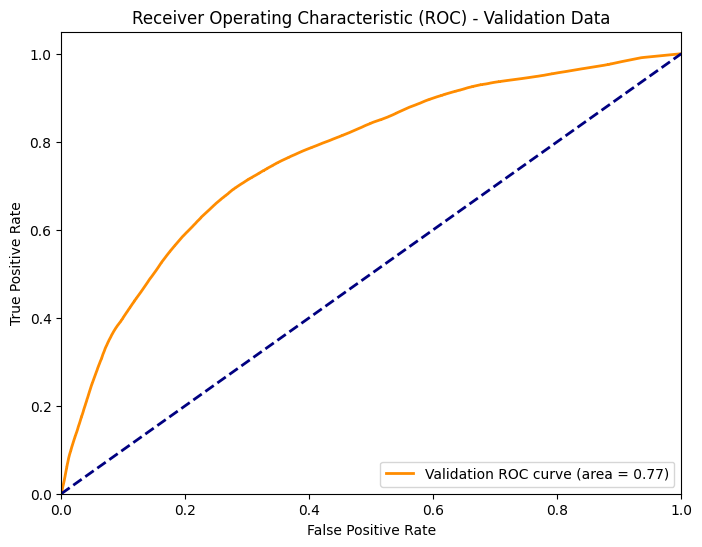

Model evaluation completed.


In [ ]:
# Define the hyperparameter grid
param_dist = [
    {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2]},
    {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['saga', 'lbfgs'], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2]},
    {'penalty': ['elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0.1, 0.5, 0.7, 0.9], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2]},
    {'penalty': [None], 'solver': ['saga'], 'max_iter': [100, 200, 500], 'tol': [1e-4, 1e-3, 1e-2]}]

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss',
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize the Logistic Regression model
model_lr = LogisticRegression(random_state=42)

# Initialize Random Search
random_search = RandomizedSearchCV(estimator=model_lr, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Fit Random Search on the training data
random_search.fit(X_trainval, y_trainval)

# Get the best model from Random Search
best_model_lr = random_search.best_estimator_
joblib.dump(best_model_lr, 'Output/best_model_lr.pkl')

# Print the best model parameters
print(f"\nBest model parameters: {random_search.best_params_}\n")

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_lr = pd.DataFrame(random_search.cv_results_)
results_lr.to_csv('Output/results_lr.csv', index=False)

# Compute and print the confusion matrix for the validation data
y_pred_val_mlp = cross_val_predict(best_model_lr, X_trainval, y_trainval, cv=kf, method='predict')

conf_matrix = confusion_matrix(y_trainval, y_pred_val_mlp)
print("Confusion Matrix:")
print(conf_matrix)

# Compute ROC curve and ROC area for validation data
y_proba_val_lr = cross_val_predict(best_model_lr, X_trainval, y_trainval, cv=kf, method='predict_proba')[:, 1]

fpr_val_lr, tpr_val_lr, thresholds_val_lr = roc_curve(y_trainval, y_proba_val_lr)
roc_auc_val_lr = auc(fpr_val_lr, tpr_val_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val_lr, tpr_val_lr, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_lr.png')

plt.show()

print("Model evaluation completed.")

### Decision Tree

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=20; total time= 1.6min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=20; total time= 1.6min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=10; total time= 1.6min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=20, min_samples_split=20; total time= 1.6min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=10; total time= 1.1min
[CV] END criterion=entropy, max_depth=15, min_samples_leaf=30, min_samples_split=10; total time= 1.1min
[CV] END criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=20; total time= 1.3min
[CV] END criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=20; total time= 1.3min
[CV] END criterion=entropy, max_depth=25, min_samples_leaf=30, min_samples_split=20; total time= 1.2min
[CV

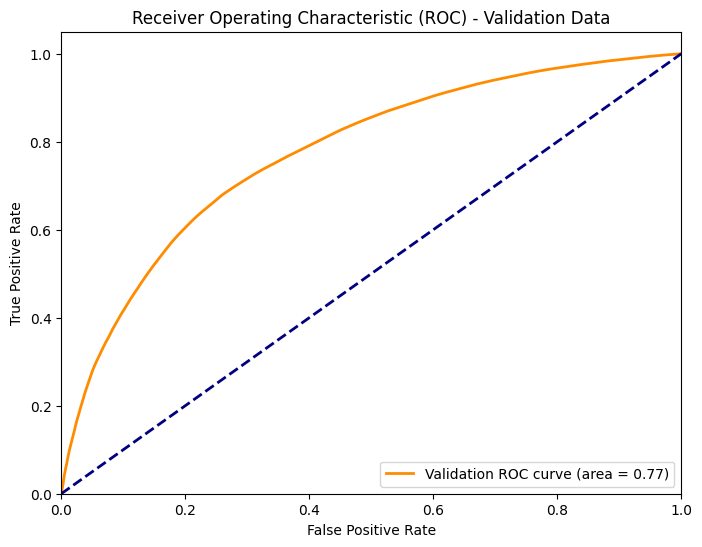

Model evaluation completed.


In [ ]:
# Define the hyperparameter grid
param_dist = {'criterion': ['gini', 'entropy'], # function to measure the quality of a split
              'max_depth': [10, 15, 20, 25, None], # maximum depth of the tree
              'min_samples_split': [10, 20, 30, 40], # minimum number of samples required to split an internal node
              'min_samples_leaf': [5, 10, 20, 30] # minimum number of samples allowed at a leaf node
}

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss',
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize the Decision Tree model
model_dt = DecisionTreeClassifier(random_state=42)

# Initialize Random Search
random_search = RandomizedSearchCV(estimator=model_dt, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Fit Random Search on the training data
random_search.fit(X_trainval, y_trainval)

# Get the best model from Random search
best_model_dt = random_search.best_estimator_
joblib.dump(best_model_dt, 'Output/best_model_dt.pkl')

# Print the best model parameters
print(f"\nBest model parameters: {random_search.best_params_}\n")

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_dt = pd.DataFrame(random_search.cv_results_)
results_dt.to_csv('Output/results_dt.csv', index=False)

# Compute and print the confusion matrix for the validation data
y_pred_val_mlp = cross_val_predict(best_model_dt, X_trainval, y_trainval, cv=kf, method='predict')

conf_matrix = confusion_matrix(y_trainval, y_pred_val_mlp)
print("Confusion Matrix:")
print(conf_matrix)

# Compute ROC curve and ROC area for validation data
y_proba_val_dt = cross_val_predict(best_model_dt, X_trainval, y_trainval, cv=kf, method='predict_proba')[:, 1]

fpr_val_dt, tpr_val_dt, thresholds_val_dt = roc_curve(y_trainval, y_proba_val_dt)
roc_auc_val_dt = auc(fpr_val_dt, tpr_val_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val_dt, tpr_val_dt, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_dt.png')

plt.show()

print("Model evaluation completed.")

### Random Forest

Fitting 3 folds for each of 25 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best model parameters: {'n_estimators': 250, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 25, 'criterion': 'entropy'}

Training accuracy of the best model: 0.723030954814457
Training precision of the best model: 0.7304610943456153
Training recall of the best model: 0.706918064573775
Training f1 of the best model: 0.7184940529172277
Training AUC of the best model: 0.7972218953501716

Validation accuracy of the best model: 0.7137807144185087
Validation precision of the best model: 0.7209586379254339
Validation recall of the best model: 0.6975518001446884
Validation f1 of the best model: 0.7090589028528068
Validation AUC of the best model: 0.7803679637313449

Confusion Matrix:
[[410334 151759]
 [170005 392089]]


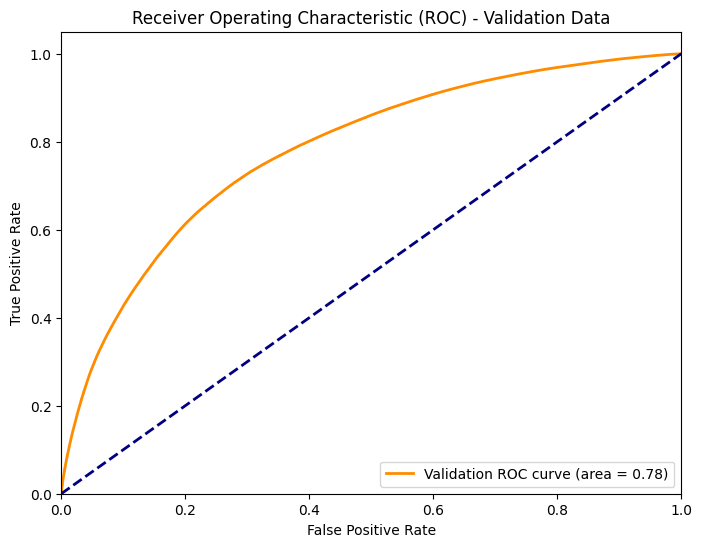

Model evaluation completed.


In [ ]:
# Define the hyperparameter grid
param_dist = {'criterion': ['gini', 'entropy'], # function to measure the quality of a split
              'max_depth': [10, 15, 20, 25, None], # maximum depth of the tree
              'min_samples_split': [20, 30, 40, 50], # minimum number of samples required to split an internal node
              'min_samples_leaf': [20, 30, 40, 50], # minimum number of samples allowed at a leaf node
              'n_estimators': [100, 150, 200, 250, 300]} # number of trees in the forest

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss',
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize the Random Forest model
model_rf = RandomForestClassifier(random_state=42)

# Initialize Random Search
random_search = RandomizedSearchCV(estimator=model_rf, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Fit Random Search on the training data
random_search.fit(X_trainval, y_trainval)

# Get the best model from Random search
best_model_rf = random_search.best_estimator_
joblib.dump(best_model_rf, 'Output/best_model_rf.pkl')

# Print the best model parameters
print(f"\nBest model parameters: {random_search.best_params_}\n")

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_rf = pd.DataFrame(random_search.cv_results_)
results_rf.to_csv('Output/results_rf.csv', index=False)

# Compute and print the confusion matrix
y_pred_val_mlp = cross_val_predict(best_model_rf, X_trainval, y_trainval, cv=kf, method='predict')

conf_matrix = confusion_matrix(y_trainval, y_pred_val_mlp)
print("Confusion Matrix:")
print(conf_matrix)

# Compute ROC curve and ROC area for validation data
y_proba_val_rf = cross_val_predict(best_model_rf, X_trainval, y_trainval, cv=kf, method='predict_proba')[:, 1]

fpr_val_rf, tpr_val_rf, thresholds_val_rf = roc_curve(y_trainval, y_proba_val_rf)
roc_auc_val_rf = auc(fpr_val_rf, tpr_val_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val_rf, tpr_val_rf, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_rf.png')

plt.show()

print("Model evaluation completed.")

### Neural Network

In [ ]:
# Build the Neural Network model
def build_model(hidden_units, hidden_layers, activation, optimizers):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(X_trainval.shape[1],)))

    # Add hidden layers
    for _ in range(hidden_layers):
        model.add(layers.Dense(hidden_units))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))

    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=optimizers, loss='binary_crossentropy', metrics=['accuracy'])

    return model

[CV] END .................................................... total time= 4.2min
[CV] END .................................................... total time= 3.5min
[CV] END .................................................... total time= 4.3min
Mean training accuracy: 0.7173010362155051
Mean training precision: 0.7216073779729202
Mean training recall: 0.7075881078147167
Mean training F1: 0.7145267966740868
Mean training AUC: 0.7862547823285629
Mean validation accuracy: 0.7133448438738395
Mean validation precision: 0.7175001702510766
Mean validation recall: 0.7038059674433536
Mean validation F1: 0.710584666234274
Mean validation AUC: 0.7799871312528676


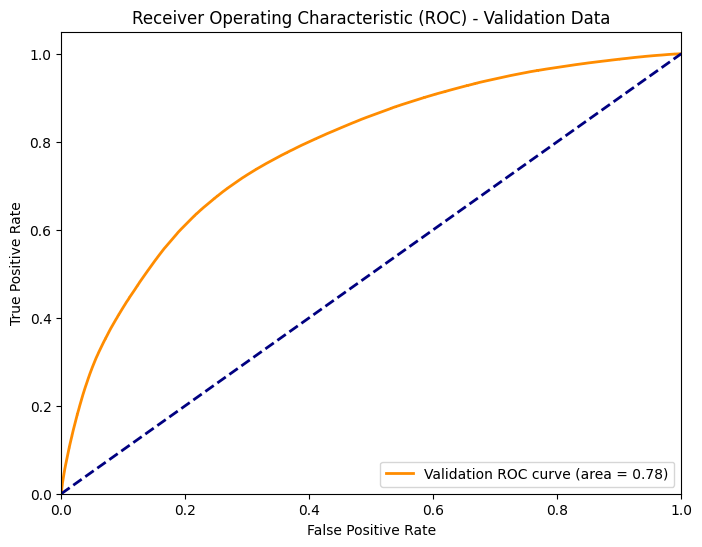

Model evaluation completed.


In [ ]:
# Fit Wiedeman 2020 on the training data
model_wiedeman = KerasClassifier(model=build_model, hidden_units=64, hidden_layers=2, activation='relu', optimizers='rmsprop', epochs=50, batch_size=10_000, verbose=0)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
scores = cross_validate(model_wiedeman, X_trainval, y_trainval, cv=kf, scoring=scoring, return_train_score=True, verbose=2)

print(f"Mean training accuracy: {scores['train_accuracy'].mean()}")
print(f"Mean training precision: {scores['train_precision'].mean()}")
print(f"Mean training recall: {scores['train_recall'].mean()}")
print(f"Mean training F1: {scores['train_f1'].mean()}")
print(f"Mean training AUC: {scores['train_roc_auc'].mean()}")

print(f"Mean validation accuracy: {scores['test_accuracy'].mean()}")
print(f"Mean validation precision: {scores['test_precision'].mean()}")
print(f"Mean validation recall: {scores['test_recall'].mean()}")
print(f"Mean validation F1: {scores['test_f1'].mean()}")
print(f"Mean validation AUC: {scores['test_roc_auc'].mean()}")

results_wiedeman = pd.DataFrame(scores)
results_wiedeman.to_csv('Output/results_wiedeman.csv', index=False)

# Compute ROC curve and ROC area for validation data
y_proba_val_wiedeman = cross_val_predict(model_wiedeman, X_trainval, y_trainval, cv=kf, method='predict_proba')[:, 1]

fpr_val_wiedeman, tpr_val_wiedeman, thresholds_val_wiedeman = roc_curve(y_trainval, y_proba_val_wiedeman)
roc_auc_val_wiedeman = auc(fpr_val_wiedeman, tpr_val_wiedeman)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val_wiedeman, tpr_val_wiedeman, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_wiedeman:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_wiedeman.png')

plt.show()

print("Model evaluation completed.")

warnings.filterwarnings("ignore", category=UserWarning, message="``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.")

Fitting 3 folds for each of 25 candidates, totalling 75 fits


2024-11-28 15:55:44.708571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 15:55:44.709660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 15:55:44.715658: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 15:55:44.724133: I tensorflow/core/platform/cpu_featu

[CV] END epochs=10, model__activation=tanh, model__hidden_layers=2, model__hidden_units=16, model__optimizers=rmsprop; total time= 6.3min
[CV] END epochs=10, model__activation=tanh, model__hidden_layers=2, model__hidden_units=16, model__optimizers=rmsprop; total time= 5.7min
[CV] END epochs=10, model__activation=tanh, model__hidden_layers=2, model__hidden_units=16, model__optimizers=rmsprop; total time= 6.3min
[CV] END epochs=50, model__activation=relu, model__hidden_layers=2, model__hidden_units=32, model__optimizers=adam; total time=13.1min
[CV] END epochs=50, model__activation=relu, model__hidden_layers=4, model__hidden_units=128, model__optimizers=adam; total time=35.8min
[CV] END epochs=50, model__activation=relu, model__hidden_layers=4, model__hidden_units=128, model__optimizers=adam; total time=39.4min
[CV] END epochs=50, model__activation=relu, model__hidden_layers=2, model__hidden_units=32, model__optimizers=adam; total time=10.2min
[CV] END epochs=50, model__activation=relu, 

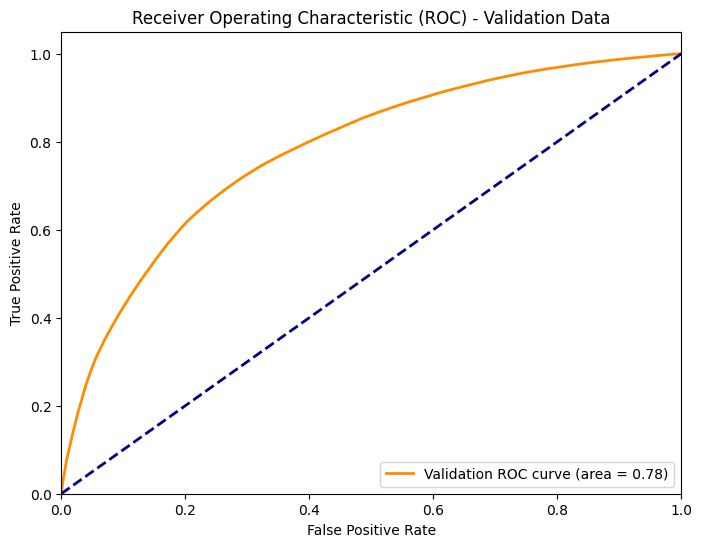

Grid search and model evaluation completed.


In [ ]:
# Initialize KerasClassifier
model_mlp = KerasClassifier(model=build_model, verbose=0)

# Define the hyperparameter grid
param_dist = {
    'model__hidden_units': [16, 32, 64, 128],              # Varying number of units in each hidden layer
    'model__hidden_layers': [1, 2, 3, 4],                  # Number of hidden layers
    'model__activation': ['relu', 'leaky_relu', 'tanh'],   # Activation functions for hidden layers
    'epochs': [10, 20, 30, 40, 50],                        # Number of training epochs
    'model__optimizers': ['adam', 'rmsprop']               # Optimizers
}

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss',
           'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'auc': 'roc_auc'}

# Initialize Random Search
random_search = RandomizedSearchCV(estimator=model_mlp, param_distributions=param_dist,
    n_iter=25, scoring=scoring, refit='accuracy', cv=kf, verbose=2, n_jobs=-1, return_train_score=True, random_state=42)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Fit Random Search on the training data
random_search.fit(X_trainval, y_trainval, batch_size=10_000, callbacks=[early_stopping])

# Get the best model from Random search
best_model_mlp = random_search.best_estimator_
joblib.dump(best_model_mlp, 'Output/best_model_mlp.pkl')

# Print the best model parameters
print(f"\nBest model parameters: {random_search.best_params_}\n")

# Print the evaluation metrics for the training data
print(f"Training accuracy of the best model: {random_search.cv_results_['mean_train_accuracy'][random_search.best_index_]}")
print(f"Training precision of the best model: {random_search.cv_results_['mean_train_precision'][random_search.best_index_]}")
print(f"Training recall of the best model: {random_search.cv_results_['mean_train_recall'][random_search.best_index_]}")
print(f"Training f1 of the best model: {random_search.cv_results_['mean_train_f1'][random_search.best_index_]}")
print(f"Training AUC of the best model: {random_search.cv_results_['mean_train_auc'][random_search.best_index_]}\n")

# Print the evaluation metrics for the validation data
print(f"Validation accuracy of the best model: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]}")
print(f"Validation precision of the best model: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]}")
print(f"Validation recall of the best model: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]}")
print(f"Validation f1 of the best model: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]}")
print(f"Validation AUC of the best model: {random_search.cv_results_['mean_test_auc'][random_search.best_index_]}\n")

results_mlp = pd.DataFrame(random_search.cv_results_)
results_mlp.to_csv('Output/results_mlp.csv', index=False)

# Compute and print the confusion matrix
y_pred_val_mlp = cross_val_predict(best_model_mlp, X_trainval, y_trainval, cv=kf, method='predict')

conf_matrix = confusion_matrix(y_trainval, y_pred_val_mlp)
print("Confusion Matrix:")
print(conf_matrix)

# Compute ROC curve and ROC area for validation data
y_proba_val_mlp = cross_val_predict(best_model_mlp, X_trainval, y_trainval, cv=kf, method='predict_proba')[:, 1]

fpr_val_mlp, tpr_val_mlp, thresholds_val_mlp = roc_curve(y_trainval, y_proba_val_mlp)
roc_auc_val_mlp = auc(fpr_val_mlp, tpr_val_mlp)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val_mlp, tpr_val_mlp, color='darkorange', lw=2, label=f'Validation ROC curve (area = {roc_auc_val_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation Data')
plt.legend(loc='lower right')

plt.savefig('Output/roc_mlp.png')

plt.show()

print("Grid search and model evaluation completed.")

warnings.filterwarnings("ignore", category=UserWarning, message="``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.")

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5877 - loss: 0.6854 - val_accuracy: 0.6795 - val_loss: 0.6125
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6851 - loss: 0.5993 - val_accuracy: 0.6965 - val_loss: 0.5880
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7007 - loss: 0.5842 - val_accuracy: 0.7028 - val_loss: 0.5804
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7051 - loss: 0.5789 - val_accuracy: 0.7058 - val_loss: 0.5775
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7068 - loss: 0.5774 - val_accuracy: 0.7077 - val_loss: 0.5759
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7078 - loss: 0.5760 - val_accuracy: 0.7083 - val_loss: 0.5745
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7087 - loss: 0.5744 - val_accuracy: 0.7090 - val_loss: 0.5733
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7082 - loss: 0.5736 - val_accuracy: 0.7098 - v

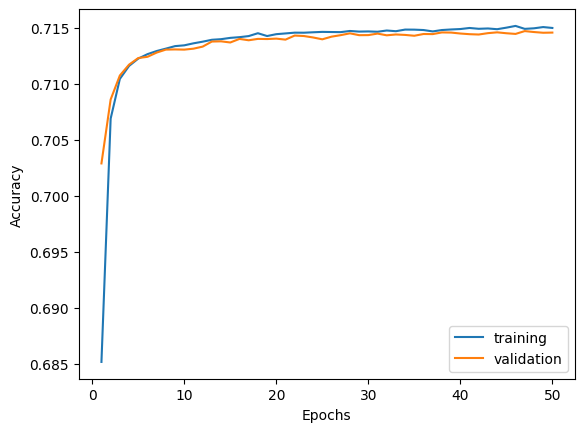

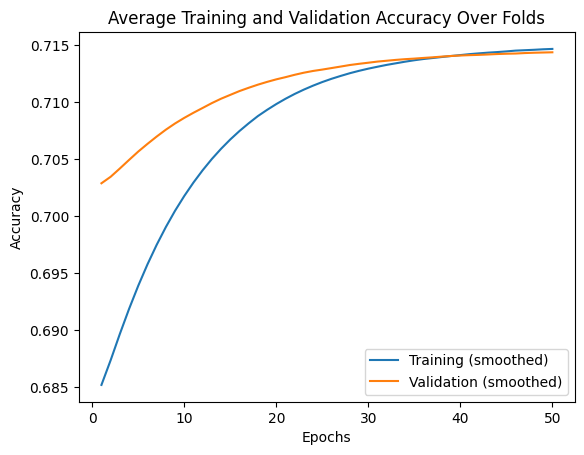

In [ ]:
# Plot the learning curves 
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

best_model = build_model(hidden_layers=3, hidden_units=16, activation='tanh', optimizers='rmsprop')

# Store histories of each fold
train_histories = []
val_histories = []

for train_index, val_index in kf.split(X_trainval, y_trainval):
    X_train_fold, X_val_fold = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
    y_train_fold, y_val_fold = y_trainval[train_index], y_trainval[val_index]

    # Train the model for the current fold
    history = best_model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, batch_size=10_000)

    # Collect the accuracy history
    train_histories.append(history.history['accuracy'])
    val_histories.append(history.history['val_accuracy'])

# Calculate the average history for training and validation
train_histories = np.array(train_histories)
val_histories = np.array(val_histories)

avg_train_history = np.mean(train_histories, axis=0)
avg_val_history = np.mean(val_histories, axis=0)

# Smooth the averaged curves
smooth_avg_train_history = smooth_curve(avg_train_history)
smooth_avg_val_history = smooth_curve(avg_val_history)

# Plot the average training and validation histories
plt.plot(range(1, len(avg_train_history) + 1), avg_train_history)
plt.plot(range(1, len(avg_val_history) + 1), avg_val_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.show()

# Plot the smoothed average training and validation histories
plt.plot(range(1, len(smooth_avg_train_history) + 1), smooth_avg_train_history)
plt.plot(range(1, len(smooth_avg_val_history) + 1), smooth_avg_val_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training (smoothed)', 'Validation (smoothed)'])
plt.title('Average Training and Validation Accuracy Over Folds')
plt.show()

## Test Best Model on Test Set

Training Set Performance:
Accuracy: 0.7147476354022951
Precision: 0.7148848401377492
Recall: 0.7147476354022951
F1 Score: 0.7147020998039092
Confusion Matrix: 
[[394654 167440]
 [153237 408856]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.73      0.72    562093
           1       0.72      0.70      0.71    562094

    accuracy                           0.71   1124187
   macro avg       0.71      0.71      0.71   1124187
weighted avg       0.71      0.71      0.71   1124187

Test Set Performance:
Accuracy: 0.7142826644653741
Precision: 0.7144153483268619
Recall: 0.7142826644653741
F1 Score: 0.7142384348682306
Confusion Matrix: 
[[ 98625  41898]
 [ 38402 102122]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.73      0.72    140524
           1       0.72      0.70      0.71    140523

    accuracy                           0.71    281047
   macro avg       0.

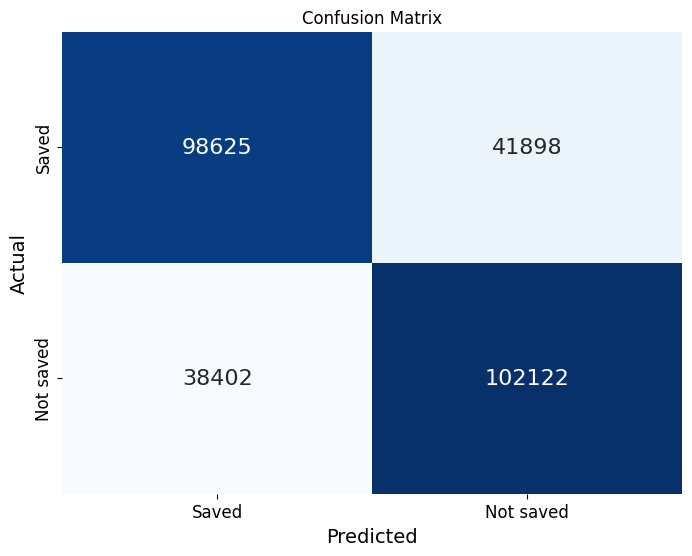

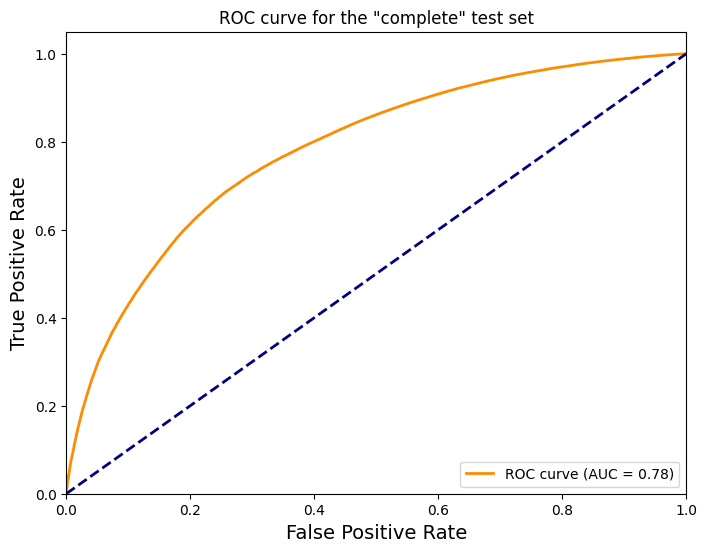

In [ ]:
# Load the best model from the .pkl file
best_model_mlp = joblib.load('Output/best_model_mlp.pkl')

# Evaluate the best model on the test data
y_pred = best_model_mlp.predict(X_test)
y_pred_train = best_model_mlp.predict(X_trainval)

# Compute the evaluation metrics
train_accuracy = accuracy_score(y_trainval, y_pred_train)
train_precision = precision_score(y_trainval, y_pred_train, average='weighted')
train_recall = recall_score(y_trainval, y_pred_train, average='weighted')
train_f1 = f1_score(y_trainval, y_pred_train, average='weighted')
train_conf_matrix = confusion_matrix(y_trainval, y_pred_train)[::-1, ::-1]
train_class_report = classification_report(y_trainval, y_pred_train)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)[::-1, ::-1]
class_report = classification_report(y_test, y_pred)

# Print the results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print(f"Confusion Matrix: \n{train_conf_matrix}")
print(f"Classification Report: \n{train_class_report}")

print("Test Set Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Classification Report: \n{class_report}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Saved', 'Not saved'], yticklabels=['Saved', 'Not saved'], annot_kws={"size": 16})

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Compute ROC curve and ROC area for test data
y_prob = best_model_mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC curve for the "complete" test set')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right')
plt.show()

## Feature Importance

In [11]:
# Compute permutation importance
result = permutation_importance(best_model_mlp, X_test, y_test, n_repeats=1, random_state=42)
joblib.dump(result, 'result_permutation.pkl')

['result_permutation.pkl']

([0, 1, 2, 3],
 [Text(0, 0, 'Scenario features'),
  Text(0, 1, 'Road Traffic Deaths'),
  Text(0, 2, 'Technology Readiness Index'),
  Text(0, 3, 'K-Prototype Clustering')])

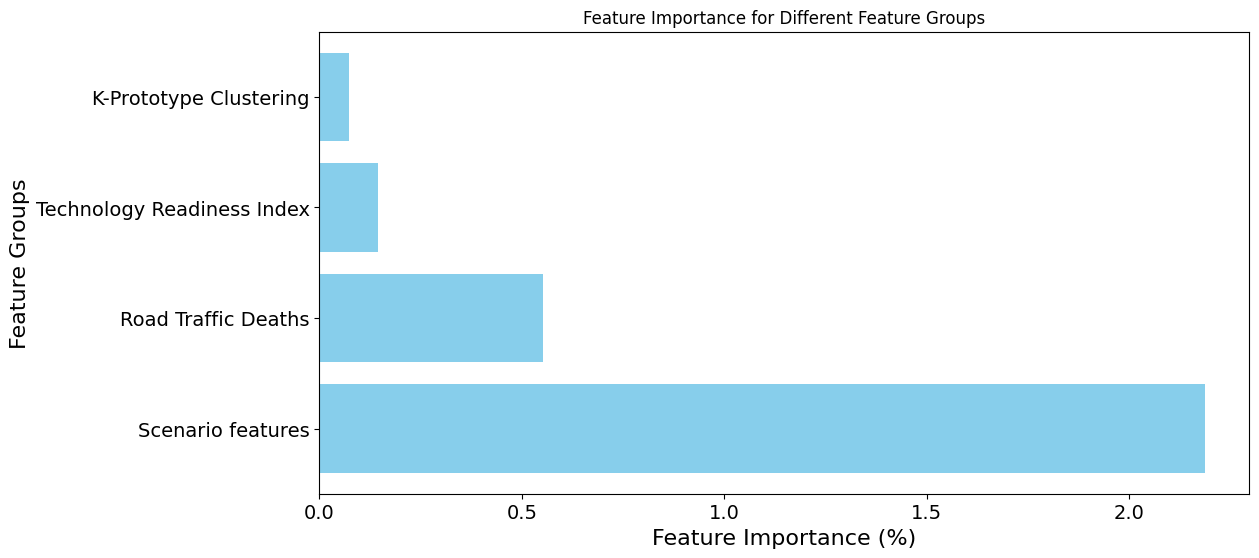

In [ ]:
result = joblib.load('Output/result_permutation.pkl')

all_indices = range(len(X_trainval.columns))

all_feature_importances = result.importances_mean[all_indices]
total_importance = all_feature_importances.sum()

importance_percentages = (all_feature_importances / total_importance) * 100

# Scenario feature importance
scenario_features = ['PedPed', 'Barrier', 'NumberOfCharacters', 'DiffNumberOFCharacters', 'Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat', 'AttributeLevel_Female', 'AttributeLevel_Fit', 'AttributeLevel_High', 'AttributeLevel_Hoomans', 'AttributeLevel_Less', 'AttributeLevel_Low', 'AttributeLevel_Male', 'AttributeLevel_More', 'AttributeLevel_Old', 'AttributeLevel_Pets', 'AttributeLevel_Rand', 'AttributeLevel_Young', 'ScenarioTypeStrict_Fitness', 'ScenarioTypeStrict_Gender', 'ScenarioTypeStrict_Random', 'ScenarioTypeStrict_Social Status', 'ScenarioTypeStrict_Species', 'ScenarioTypeStrict_Utilitarian', 'CrossingSignal_1', 'CrossingSignal_2']
scenario_indices = [X_trainval.columns.get_loc(feature) for feature in scenario_features]
scenario_importance_percentages = importance_percentages[scenario_indices]
scenario_feature_importance = scenario_importance_percentages.mean()

# Availibility bias road traffic deaths feature importance
road_traffic_features = ['Total', 'Males', 'Females', 'Passengers', 'Pedestrians']
road_traffic_indices = [X_trainval.columns.get_loc(feature) for feature in road_traffic_features]
road_traffic_importance_percentages = importance_percentages[road_traffic_indices]
road_traffic_feature_importance = road_traffic_importance_percentages.mean()

# Availibility bias technology readiness index feature importance
technology_readiness_features = ['Finance_access', 'ICT', 'Industry_activity', 'Overall_index', 'Research_and_development', 'Skills']
technology_readiness_indices = [X_trainval.columns.get_loc(feature) for feature in technology_readiness_features]
technology_readiness_importance_percentages = importance_percentages[technology_readiness_indices]
technology_readiness_feature_importance = technology_readiness_importance_percentages.mean()

# K-protoype clustering feature importance
k_prototype_features = ['Clusters_1', 'Clusters_2']
k_prototype_indices = [X_trainval.columns.get_loc(feature) for feature in k_prototype_features]
k_prototype_importance_percentages = importance_percentages[k_prototype_indices]
k_prototype_feature_importance = k_prototype_importance_percentages.mean()

group_names = ['Scenario features', 'Road Traffic Deaths', 'Technology Readiness Index', 'K-Prototype Clustering']
group_importances = [scenario_feature_importance, road_traffic_feature_importance, technology_readiness_feature_importance, k_prototype_feature_importance]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.barh(group_names, group_importances, color='skyblue')
plt.xlabel('Feature Importance (%)', fontsize=16)  # Set font size for x-axis label
plt.ylabel('Feature Groups', fontsize=16)          # Set font size for y-axis label
plt.title('Feature Importance for Different Feature Groups', fontsize=12)       # Set font size for title
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

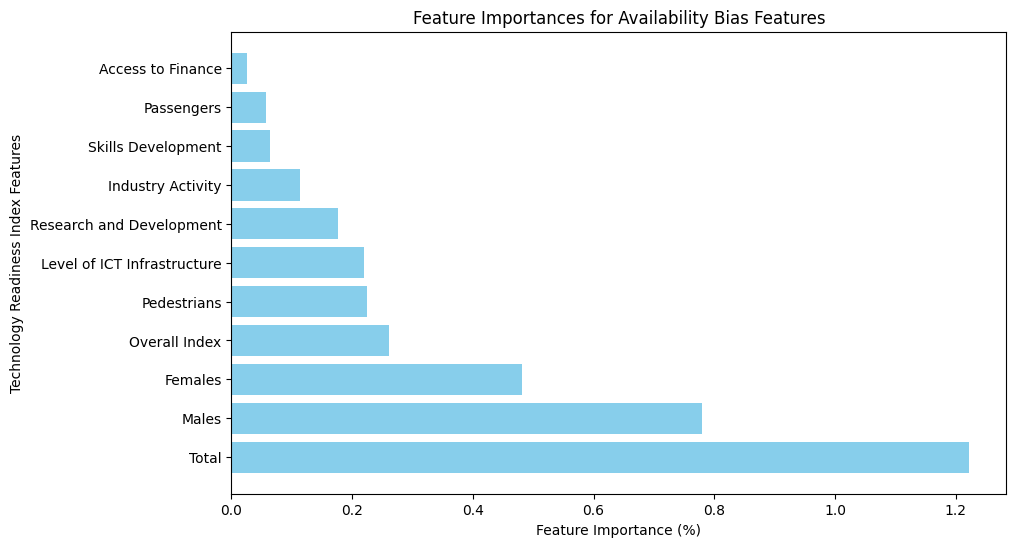

In [ ]:
feature_names = ['Finance_access', 'ICT', 'Industry_activity', 'Overall_index', 'Research_and_development', 'Skills', 'Total', 'Males', 'Females', 'Passengers', 'Pedestrians']
feature_name_map = {'Finance_access': 'Access to Finance', 'ICT': 'Level of ICT Infrastructure', 'Industry_activity': 'Industry Activity', 'Overall_index': 'Overall Index', 'Research_and_development': 'Research and Development', 'Skills': 'Skills Development', 'Total':'Total', 'Males':'Males', 'Females':'Females', 'Passengers':'Passengers', 'Pedestrians':'Pedestrians'}

selected_indices = [X_trainval.columns.get_loc(feature) for feature in feature_names]

# Plot feature importances
feature_importances_percentages = importance_percentages[selected_indices]

# Sort the feature importances and names in descending order
sorted_indices = np.argsort(feature_importances_percentages)[::-1]
sorted_feature_importances = feature_importances_percentages[sorted_indices]
sorted_feature_names = [feature_name_map[feature_names[i]] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, color="skyblue")
plt.xlabel("Feature Importance (%)")
plt.ylabel("Technology Readiness Index Features")
plt.title("Feature Importances for Availability Bias Features")
plt.show()

In [ ]:
# Create a DataFrame with feature names and their importance and relative importance
importance_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': result.importances_mean})

importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

total_importance = importance_df['Importance'].sum()
importance_df['Relative Importance (%)'] = (importance_df['Importance'] / total_importance) * 100

importance_df


,Feature,Importance,Relative Importance (%)
0,AttributeLevel_Hoomans,0.029433,11.389233
1,CrossingSignal_2,0.025978,10.052320
2,AttributeLevel_More,0.021758,8.419386
3,AttributeLevel_Young,0.020224,7.825967
4,CrossingSignal_1,0.019965,7.725458
5,NumberOfCharacters,0.013848,5.358667
6,AttributeLevel_Pets,0.013731,5.313231
7,Barrier,0.013528,5.234751
8,AttributeLevel_High,0.010621,4.109872
9,DiffNumberOFCharacters,0.010578,4.093350
